In [ ]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
sys.path.append('/projects/UNet/utils/')
import torch
import matplotlib.pyplot as plt
from UNet import UNet

In [ ]:
from huggingface_hub import hf_hub_download

repo_id = "Harish-JHR/PolygonColorizingUNet" 
filename = "pytorch_model.bin"

model_path = hf_hub_download(repo_id=repo_id, filename=filename)


in_channels = 3 + 8 
model = UNet(in_channels=in_channels)
model.load_state_dict(torch.load(model_path, map_location='cpu'))

model.eval()
print("Model loaded")


/ssd_scratch/harish.j/miniconda3/envs/sr_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded


/tmp/ipykernel_946249/989002140.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'))


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def infer_single_image(image_path, color_str, model, color_list, img_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img = Image.open(image_path).convert("RGB")
    img = img.resize((img_size, img_size))
    img_tensor = transforms.ToTensor()(img)

    # Onehot encodig of color
    color_str = color_str.lower()
    if color_str not in color_list:
        raise ValueError(f"Color '{color_str}' not found")
    color_idx = color_list.index(color_str)
    color_tensor = torch.nn.functional.one_hot(
        torch.tensor(color_idx), num_classes=len(color_list)
    ).float().view(len(color_list), 1, 1).expand(-1, img_size, img_size)

    # Combine input image and condition
    conditioned_input = torch.cat([img_tensor, color_tensor], dim=0).unsqueeze(0).to(device) 

    # Load model to device
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(conditioned_input)[0].cpu().clamp(0, 1)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img_tensor.permute(1, 2, 0))
    axs[0].set_title("Input")
    axs[0].axis("off")

    axs[1].imshow(output.permute(1, 2, 0))
    axs[1].set_title(f"Output (Color: {color_str})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


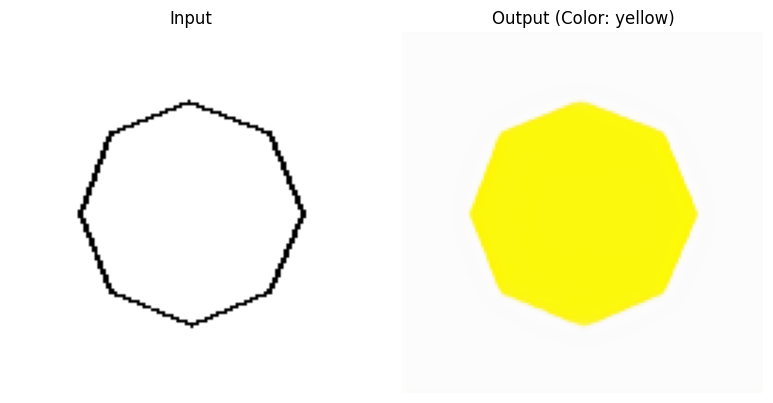

In [ ]:
# Ex : 
color_list = ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow'] 
infer_single_image(
    image_path="/projects/UNet/data/validation/inputs/octagon.png",
    color_str="yellow",
    model=model,
    color_list=color_list
)
